In [1]:
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox # Matplotlib widgets
import matplotlib.pylab as plt # Plotting interface
import numpy as np
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, RazorThinExponentialDiskPotential, BurkertPotential # GALPY potentials
from galpy.potential import calcRotcurve # composed rotation curve calculation for plotting
from astropy import units # Physical/real units data managing
from astropy import table as Table # For fast and easy reading / writing with tables using numpy library
import emcee
import corner
import time
import pandas as pd
import multiprocessing as mp
from scipy.optimize import fsolve


import ipywidgets as widgets


  Referenced from: /Library/Python/3.7/site-packages/libgalpy.cpython-37m-darwin.so
  Reason: image not found' 


In [2]:
#input_params=Table.Table.read('../input_params.txt', format='ascii.tab') # Initial parameters
#input_params

In [2]:
data_rows = [('BULGE', 110000000.0, 1.0, 0.0, 20, 0.495, 70),
             ('THIN DISK', 3900000000.0, 1.0, 5.3, 90, 0.25, 1),
             ('THICK DISK', 39000000000.0, 0.5, 2.6, 20, 0.8, 1),
             ('EXP DISK', 500.0, 0.5, 5.3, 90, 0.0, 0),
             ('DARK HALO', 140000000000.0, 1.0, 13.0, 90, 0.0, 0),
             ('BURKERT HALO', 8000000.0, 1.0, 20.0, 90, 0.0, 0)]
input_params = Table.Table(rows=data_rows, names=('component', 'mass', 'threshold_mass', 'a (kpc)', 'threshold_a', 'b (kpc)', 'threshold_b'))
input_params


component,mass,threshold_mass,a (kpc),threshold_a,b (kpc),threshold_b
str12,float64,float64,float64,int64,float64,int64
BULGE,110000000.0,1.0,0.0,20,0.495,70
THIN DISK,3900000000.0,1.0,5.3,90,0.25,1
THICK DISK,39000000000.0,0.5,2.6,20,0.8,1
EXP DISK,500.0,0.5,5.3,90,0.0,0
DARK HALO,140000000000.0,1.0,13.0,90,0.0,0
BURKERT HALO,8000000.0,1.0,20.0,90,0.0,0


In [167]:
init_guess_params = Table.Table.read('../init_guess_params.txt', format='ascii.tab') # Initial parameters
init_guess_params

component,mass,a (kpc),b (kpc),checked
str12,float64,float64,float64,str5
BULGE,110000000.0,0.0,0.495,False
THIN DISC,7118985055.444256,2.740511736223358,0.10709714693766031,False
THICK DISC,39000000000.0,2.6,0.8,True
EXP. DISC,500.0,5.3,0.0,False
DARK HALO,257638242273.6968,16.277150721161576,0.0,True
BURKERT HALO,8000000.0,20.0,0.0,False


In [176]:
def boolString_to_bool(boolString):
    if boolString == 'True':
        return True
    elif boolString == 'False':
        return False
    else:
        return None

In [178]:
boolString_to_bool('Falase')

In [162]:
init_guess_params.fill_value = 0

In [164]:
init_guess_params.filled()

component,mass,a (kpc),b (kpc),checked
str12,float64,float64,str19,str5
BULGE,110000000.0,0.0,0.495,False
THIN DISC,7118985055.444256,2.740511736223358,0.10709714693766031,True
THICK DISC,39000000000.0,2.6,0.8,False
EXP. DISC,500.0,5.3,None,False
DARK HALO,257638242273.6968,16.277150721161576,None,True
BURKERT HALO,8000000.0,20.0,None,False


# If no args

In [10]:
c_bulge, amp1, delta_mass_bulge, a1, delta_radial_bulge, b1, delta_vertical_bulge, include_bulge = *input_params[0], True
c_tn, amp2, delta_mass_tn, a2, delta_radial_tn, b2, delta_vertical_tn, include_tn = *input_params[1], True
c_tk, amp3, delta_mass_tk, a3, delta_radial_tk, b3, delta_vertical_tk, include_tk = *input_params[2], True
c_ex, amp4, delta_mass_ex, h_r, delta_radial_ex, vertical_ex, delta_vertical_ex, include_ex = *input_params[3], True
c_dh, amp5, delta_mass_dh, a5, delta_radial_dh, b5, delta_vertical_dh, include_dh = *input_params[4], True
c_bh, amp6, delta_mass_bh, a6, delta_radial_bh, b6, delta_vertical_bh, include_bh = *input_params[5], True


# With args

In [150]:
c_bulge, amp1, a1, b1, include_bulge = init_guess_params[0]
c_tn, amp2, a2, b2, include_tn = init_guess_params[1]
c_tk, amp3, a3, b3, include_tk = init_guess_params[2]
c_ex, amp4, h_r, vertical_ex, include_ex = init_guess_params[3]
c_dh, amp5, a5, b5, include_dh = init_guess_params[4]
c_bh, amp6, a6, b6, include_bh = init_guess_params[5]


In [160]:
c_bh, amp6, a6, b6, include_bh

('BURKERT HALO', 8000000.0, 20.0, 'None', 'False')

In [152]:
include_bulge = bool(include_bulge)

In [153]:
include_bulge

True

In [133]:
args1 = 'input.py a_curve.txt --gui bulge disk halo'

In [156]:
args2 = 'input.py a_curve.txt --gui --guess=abc.txt'

In [135]:
args3 = 'input.py a_curve.txt'

In [143]:
args4 = 'input.py'

In [157]:
rot_curve_file = 'rot_curve.txt'
has_gui = False
has_guess = False
guess_table = 'init_guess_params.txt'

optional_potentials = set()

warnings_args = []

complete_args = args4.split()

for (i, arg) in enumerate(complete_args):
    print(arg)
    if i == 1:
        rot_curve_file = arg
        warnings_args.append("Using '"+arg+"' as the rotation curve file.")
    if ('--gui' == arg) and (i > 1):
        has_gui = has_gui or True
    if '--guess' in arg:
        guess_arg = arg.split(sep='=')
        if len(guess_arg) == 2:
            guess_table = guess_arg[-1]
            has_guess = has_guess or True
        
        if has_bulge or has_disk or has_halo :
            warnings_args.append("You will use '--guess' option but some potentials ('bulge', 'disk' or 'halo') are in your args too. There will be used the guess txt file.")
            
    if 'bulge' == arg:
        optional_potentials.add('bulge')
    if 'disk' == arg:
        optional_potentials.add('disk')
    if 'halo' == arg:
        optional_potentials.add('halo')

if len(warnings_args) > 0:
    print("Warning: ", warnings_args) 

input.py


In [158]:
guess_table

'init_guess_params.txt'

In [138]:
ALLOWED_OPTIONS = [{'bulge', 'halo'}, {'disk', 'halo'}, {'bulge', 'disk', 'halo'}]
ALLOWED_POTENTIALS = ["bulge", "disk", "thickDisk", "expDisk", "halo", "burkert"]


In [149]:
ALLOWED_OPTIONS[0]

{'bulge', 'halo'}

In [139]:
visibility = [True, True, True, True, True, True]
for (i, potential) in enumerate(ALLOWED_POTENTIALS):
    if potential in optional_potentials:
        visibility[i] = True
    else:
        visibility[i] = False

In [140]:


if has_guess:
    print('Using table', guess_table)
elif optional_potentials in ALLOWED_OPTIONS:
    print('Using optional potentials', optional_potentials)



Verified optional potentials {'bulge', 'disk', 'halo'}


In [ ]:
valid_argv = True
visibility = [True, True, True, True, True, True]
if (len(complete_args) > 2):
    """for (i, potential) in enumerate(ALLOWED_POTENTIALS):
        if potential in sys.argv:
            visibility[i] = True
        else:
            visibility[i] = False"""

    """for i in sys.argv[2:]:
        if i not in ALLOWED_ARGS:
            valid_argv = valid_argv and False"""
    if valid_argv:
        # Rotation curve fitting
        if ("bulge" in sys.argv) and ("halo" in sys.argv):
            print("FIT---BULGE + HALO")
        if ("bulge" in sys.argv) and ("disk" in sys.argv) and ("halo" in sys.argv):
            print("FIT---BULGE + DISK + HALO")
        if ("disk" in sys.argv) and ("halo" in sys.argv):
            print("FIT---DISK + HALO")
else:
    amp1, a1, b1 = input_component(c_bulge, amp1, a1, b1)
    amp2, a2, b2 = input_component(c_tn, amp2, a2, b2)
    amp3, a3, b3 = input_component(c_tk, amp3, a3, b3)
    amp4, h_r, vertical_ex = input_component(c_ex, amp4, h_r, vertical_ex)
    amp5, a5, b5 = input_component(c_dh, amp5, a5, b5)
    amp6, a6, b6 = input_component(c_bh, amp6, a6, b6)

In [6]:
import enum

In [7]:
"""class Components_names(enum.Enum):
    Bulge = 'Bulge'
    Thin_disk = 'Thin disk'
    Thick_disk = 'Thick disk'
    Exponential_disk = 'Exponential disk'
    Dark_halo = 'Dark halo'
    Burkert_halo = 'Burkert halo'"""
    

def input_component(component, guess_mass, guess_a, guess_b):
    
    component_mass, component_scale_a, component_scale_b = guess_mass, guess_a, guess_b
    
    print('Set the guess parameters for', component)
    try:
        component_mass = float(input('Mass (in M_sun):'))
    except:
        print('No valid Mass for', component, '. It will be taken the default mass:', component_mass, 'M_sun')
    
    
    try:
        component_scale_a = float(input('Radial Scale Length (in kpc):'))
    except:
        print('No valid Radial Scale Length for', component, '. It will be taken the default Radial Scale Lenght:', component_scale_a, 'kpc')

    if component not in [Components_names.Exponential_disk, Components_names.Dark_halo, Components_names.Burkert_halo]:
        try:
            component_scale_b = float(input('Vertical Scale Length (in kpc):'))
        except:
            print('No valid Vertical Scale Length for', component, '. It will be taken the default Vertical Scale Lenght:', component_scale_b, 'kpc')
    
    return component_mass, component_scale_a, component_scale_b
    
    

In [8]:
c, mass, delta_mass, radial, delta_radial, vertical, delta_vertical = input_params[0]
mass, radial, vertical = input_component(c, mass, radial, vertical)
print(mass, radial, vertical)

c, mass, delta_mass, radial, delta_radial, vertical, delta_vertical = input_params[4]
mass, radial, vertical = input_component(c, mass, radial, vertical)
print(mass, radial, vertical)


Set the guess parameters for BULGE
No valid Mass for BULGE . It will be taken the default mass: 110000000.0 M_sun
No valid Radial Scale Length for BULGE . It will be taken the default Radial Scale Lenght: 0.0 kpc


NameError: name 'Components_names' is not defined

In [2]:
import matplotlib.pyplot as plt

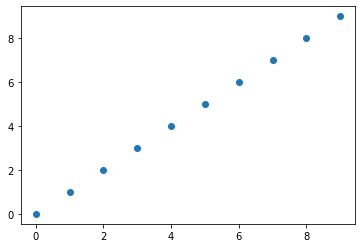

In [6]:
plt.scatter(range(10), range(10))
plt.savefig('./aa.pdf')

In [7]:
import os

In [11]:
path = './M31'

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


FileExistsError: [Errno 17] File exists: './M31'

In [18]:
path = './'

try:
    os.mkdir(path)
except FileExistsError:
    print ("Overwriting on directory %s" % path)
except OSError:
    print(OSError)
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


Overwriting on directory ./


<method 'with_traceback' of 'BaseException' objects>